<a id='top'></a>
# Reddit API and Classification

**Previous:** [Data Collection](./01_data_collection.ipynb)

## Data Cleaning and Exploratory Data Analysis
---
In our previous section, we have collected into dataframes subreddit posts from two subreddits:
- r/Android
- r/apple

In this section, we will be cleaning the data collected and then carry out some analysis based on the cleaned data.

### Library Imports

**\*Note on Installations**

As these packages are not built-in, you might want to run the following lines on your **command line** to install `wordcloud`

>```
>git clone https://github.com/amueller/word_cloud.git
>cd word_cloud
>pip install
>```

OR you can run the following code on the jupyter notebook to install `wordcloud`
>```python
>pip install git+git://github.com/amueller/word_cloud.git
>```

Run the following code on the jupyter notebook to install `matplotlib-venn` for venn diagrams

>```python 
>pip install matplotlib-venn
>```


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import seaborn as sns

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from nltk.corpus import stopwords # Import the stop word list

#uncomment to install wordcloud
#pip install git+git://github.com/amueller/word_cloud.git
from wordcloud import WordCloud
#uncomment to install venn diagram
#pip install matplotlib-venn
from PIL import Image


from bs4 import BeautifulSoup
import regex as re
import requests
import time
import random

### Data imports

In [4]:
df_android = pd.read_csv('../datasets/android_posts.csv')
df_apple = pd.read_csv('../datasets/apple_posts.csv')

### Exploring the dataframes

In [5]:
#preview first 5 rows data from android subreddit
pd.set_option('display.max_rows', None)
df_android.head().T

,0,1,2,3,4
approved_at_utc,NaN,NaN,NaN,NaN,NaN
subreddit,Android,Android,Android,Android,Android
selftext,"Note 1. Join us at /r/MoronicMondayAndroid, a ...","&gt;Separately, Brussels wants large platforms...",NaN,NaN,NaN
author_fullname,t2_6l4z3,t2_533dzk3z,t2_75e6g,t2_167ibb,t2_48kr10
saved,False,False,False,False,False
mod_reason_title,NaN,NaN,NaN,NaN,NaN
gilded,0,0,0,0,0
clicked,False,False,False,False,False
title,Moronic Monday (Sep 28 2020) - Your weekly que...,The new EU law will force companies to let you...,Google Pixel 5,New Chromecast with Google TV Available to Order!,Including expensive mmWave 5G on the Pixel 5 w...
link_flair_richtext,[],[],[],[],[]


In [6]:
#summary of android data
df_android.describe()

,approved_at_utc,mod_reason_title,gilded,pwls,downs,thumbnail_height,top_awarded_type,upvote_ratio,author_flair_background_color,ups,...,removal_reason,link_flair_background_color,report_reasons,discussion_type,num_comments,subreddit_subscribers,created_utc,num_crossposts,event_start,event_end
count,0.0,0.0,985.000000,985.0,985.0,671.000000,0.0,985.000000,0.0,985.000000,...,0.0,0.0,0.0,0.0,985.000000,9.850000e+02,9.850000e+02,985.000000,2.000000e+00,2.000000e+00
mean,NaN,NaN,0.005076,6.0,0.0,92.454545,NaN,0.837990,NaN,507.332995,...,NaN,NaN,NaN,NaN,113.415228,2.269082e+06,1.599971e+09,0.123858,1.601489e+09,1.601503e+09
std,NaN,NaN,0.071102,0.0,0.0,21.920697,NaN,0.136946,NaN,1803.530913,...,NaN,NaN,NaN,NaN,169.582603,3.035087e-01,1.081635e+06,0.482298,0.000000e+00,0.000000e+00
min,NaN,NaN,0.000000,6.0,0.0,45.000000,NaN,0.260000,NaN,0.000000,...,NaN,NaN,NaN,NaN,0.000000,2.269081e+06,1.597790e+09,0.000000,1.601489e+09,1.601503e+09
25%,NaN,NaN,0.000000,6.0,0.0,73.000000,NaN,0.790000,NaN,56.000000,...,NaN,NaN,NaN,NaN,28.000000,2.269082e+06,1.599060e+09,0.000000,1.601489e+09,1.601503e+09
50%,NaN,NaN,0.000000,6.0,0.0,93.000000,NaN,0.880000,NaN,133.000000,...,NaN,NaN,NaN,NaN,56.000000,2.269082e+06,1.600243e+09,0.000000,1.601489e+09,1.601503e+09
75%,NaN,NaN,0.000000,6.0,0.0,105.000000,NaN,0.940000,NaN,319.000000,...,NaN,NaN,NaN,NaN,125.000000,2.269082e+06,1.600871e+09,0.000000,1.601489e+09,1.601503e+09
max,NaN,NaN,1.000000,6.0,0.0,140.000000,NaN,0.980000,NaN,37324.000000,...,NaN,NaN,NaN,NaN,1946.000000,2.269082e+06,1.601525e+09,6.000000,1.601489e+09,1.601503e+09


In [7]:
#preview first 5 rows data from apple subreddit
df_apple.head().T

,0,1,2,3,4
approved_at_utc,NaN,NaN,NaN,NaN,NaN
subreddit,apple,apple,apple,apple,apple
selftext,\n\nWelcome to the daily Tech Support thread f...,I guess this will be rappleOS 20.9.1?\n\n_____...,NaN,NaN,NaN
author_fullname,t2_6l4z3,t2_ofg2i,t2_oa1us,t2_oa1us,t2_6090pcx7
saved,False,False,False,False,False
mod_reason_title,NaN,NaN,NaN,NaN,NaN
gilded,0,0,0,0,0
clicked,False,False,False,False,False
title,Daily Tech Support Thread - [September 30],[Meta] Changes coming to the subreddit re: Sel...,Apple TV is coming to Xbox consoles,Apple TV app in the works for PlayStation too,"Mark Gurman: ""Apple marketing materials for th..."
link_flair_richtext,"[{'e': 'text', 't': 'Official Megathread'}]","[{'e': 'text', 't': 'Mod Post'}]",[],[],"[{'e': 'text', 't': 'iPad'}]"


In [8]:
#summary of apple data
df_apple.describe()

,approved_at_utc,mod_reason_title,gilded,pwls,downs,thumbnail_height,top_awarded_type,upvote_ratio,author_flair_background_color,ups,...,removed_by,num_reports,mod_reason_by,removal_reason,report_reasons,discussion_type,num_comments,subreddit_subscribers,created_utc,num_crossposts
count,0.0,0.0,989.000000,989.0,989.0,685.000000,0.0,989.000000,0.0,989.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,989.000000,9.890000e+02,9.890000e+02,989.000000
mean,NaN,NaN,0.025278,6.0,0.0,86.852555,NaN,0.798595,NaN,772.820020,...,NaN,NaN,NaN,NaN,NaN,NaN,142.438827,1.807199e+06,1.600412e+09,0.169869
std,NaN,NaN,0.251248,0.0,0.0,22.887345,NaN,0.194985,NaN,2653.224533,...,NaN,NaN,NaN,NaN,NaN,NaN,456.762737,8.569955e-01,1.067826e+06,0.648466
min,NaN,NaN,0.000000,6.0,0.0,27.000000,NaN,0.060000,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.807198e+06,1.593513e+09,0.000000
25%,NaN,NaN,0.000000,6.0,0.0,73.000000,NaN,0.720000,NaN,15.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,1.807198e+06,1.600047e+09,0.000000
50%,NaN,NaN,0.000000,6.0,0.0,78.000000,NaN,0.870000,NaN,99.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,1.807199e+06,1.600559e+09,0.000000
75%,NaN,NaN,0.000000,6.0,0.0,93.000000,NaN,0.940000,NaN,378.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,118.000000,1.807200e+06,1.601130e+09,0.000000
max,NaN,NaN,4.000000,6.0,0.0,140.000000,NaN,1.000000,NaN,41162.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,7274.000000,1.807201e+06,1.601527e+09,9.000000


### Filtered dataframe
For this project, our goal is to use NLP (Natural Language Processing) to train a classifier on which subreddit a given post came from. Hence, we determined the following columns crucial for our model.
- Significant text data in 'title'
- Target variable in 'subreddit'

We will filter the columns above and create a new dataframe from there.

In [9]:
cols = ['subreddit','title']

In [10]:
df = pd.concat([df_android[cols], df_apple[cols]], axis=0, join='outer', ignore_index=True)

### Data Cleaning

In [11]:
#preview dataframe
df.head()

,subreddit,title
0,Android,Moronic Monday (Sep 28 2020) - Your weekly que...
1,Android,The new EU law will force companies to let you...
2,Android,Google Pixel 5
3,Android,New Chromecast with Google TV Available to Order!
4,Android,Including expensive mmWave 5G on the Pixel 5 w...


In [12]:
#check datatypes, null values
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1974 non-null   object
 1   title      1974 non-null   object
dtypes: object(2)
memory usage: 31.0+ KB


In [13]:
#check datatypes, null values
#we have noted no null values in our data
df.isnull().sum()

subreddit    0
title        0
dtype: int64

In [14]:
#save df checkpoint
df.to_csv('../datasets/combined_df.csv')

In [15]:
#Check data count before removing duplicates
#posts collected are quite balanced
df['subreddit'].value_counts()

apple      989
Android    985
Name: subreddit, dtype: int64

In [16]:
#check shape of dataframe
df.shape

(1974, 2)

In [17]:
#check unique titles in each dataframe
print(f"Android dataframe has {df_android['title'].nunique()} unique titles.")
print(f"Apple dataframe has {df_apple['title'].nunique()} unique titles.")


Android dataframe has 732 unique titles.
Apple dataframe has 837 unique titles.


In [18]:
#crosscheck with unique titles in combined dataframe
df['title'].nunique()

1569

In [19]:
#drop duplicated rows
df.drop_duplicates(keep='first',inplace=True)

In [20]:
# check that duplicate are dropped
df.shape

(1569, 2)

In [21]:
#check number of unique titles again
df['title'].nunique()

1569

#### Convert target variable (Android/apple) to binary labels
We will set apple to value 1 since it is the best value in our classification model.
- 0 for Android
- 1 for apple

In [22]:
df['subreddit'] = df['subreddit'].map({'Android': 0, 'apple': 1})

In [23]:
#check labels
df.head()

,subreddit,title
0,0,Moronic Monday (Sep 28 2020) - Your weekly que...
1,0,The new EU law will force companies to let you...
2,0,Google Pixel 5
3,0,New Chromecast with Google TV Available to Order!
4,0,Including expensive mmWave 5G on the Pixel 5 w...


In [24]:
#check for unbalanced classes
#slightly unbalanced Apple: "1" has more unique titles
df['subreddit'].value_counts(normalize=True)

1    0.533461
0    0.466539
Name: subreddit, dtype: float64

#### Clean text data
Lets proceed to clean the text data using a function below. <br><br>
Since we will require text data or words in our classifier, we all remove all non-letters and convert to lowercase letters for the same words to be categorised together. <br>

"stopwords" are also removed in this function below.

In [25]:
import regex as re

def raw_to_words(raw_text):
    # Function to convert raw text to a string of words
    # The input is a single string (a raw title text), and 
    # the output is a single string (a preprocessed title text)
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [26]:
#apply the function elementwise in the dataseries
#so the function is applied to every row in the dataframe
df['title'] = df['title'].map(lambda x: raw_to_words(x))
df['title']

0              moronic monday sep weekly questions thread
1       new eu law force companies let uninstall pre l...
2                                            google pixel
3                new chromecast google tv available order
4       including expensive mmwave g pixel big mistake...
5                                          google pixel g
6        google says pixel soli radar motion sense return
7                        new helpful editor google photos
8       google offering free bose qc iis pixel purchas...
9       andrew goodman joseph cherukara say goodbye ho...
10                 google tv replacing play movies amp tv
11              google pixel win high end midrange easier
12       google pay confirms old app replaced flutter one
13                sure looks like pixel pixel neural core
14                     dave lee thoughts new google pixel
15      telegram released search filters anonymous adm...
16            google put wireless charging aluminum pixel
17            

### WordCloud
Lets visualise the features collected it in a wordcloud.

In [27]:
# Define function to draw word cloud
def draw_wordcloud(text, plot_title=None, mask_img=None):

    mask = np.array(Image.open(mask_img))

    wordcloud = WordCloud(
        mask = mask,
        scale=7,
        max_words=1000,
        background_color='white',
        colormap='brg',
        contour_width=3,
        contour_color='grey',
        random_state=42
    ).generate(text)
    plt.figure(figsize=(10,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()


Some words clearly seen in the Android wordcloud: 
android, google, samsung, phone, review, camera, new, galaxy, note, fold, pixel


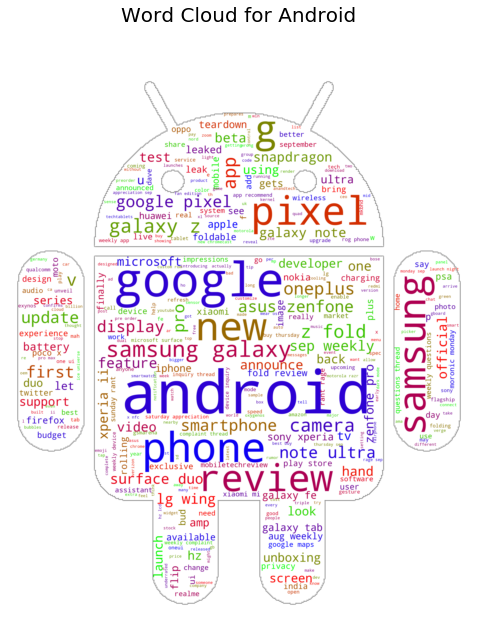

Some words clearly seen in the apple wordcloud: 
apple, app, ios, iphone, watch, widgets, new, released, support, daily, tech


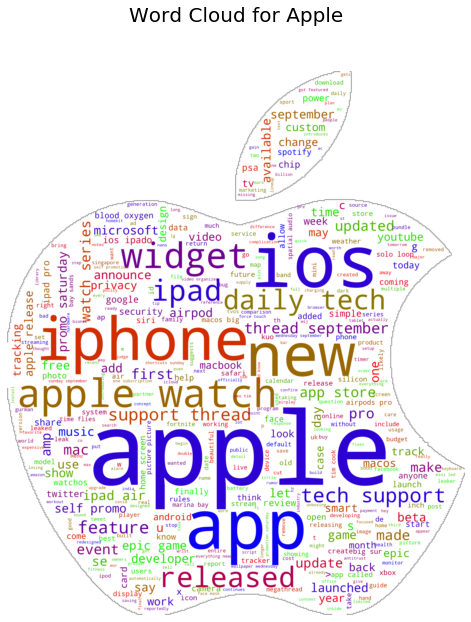

In [28]:
print('''Some words clearly seen in the Android wordcloud: 
android, google, samsung, phone, review, camera, new, galaxy, note, fold, pixel''')

draw_wordcloud(
    str(df['title'][df['subreddit']==0]),
    plot_title='Word Cloud for Android',
    mask_img = '../images/android_logo.png'
)

print('''Some words clearly seen in the apple wordcloud: 
apple, app, ios, iphone, watch, widgets, new, released, support, daily, tech''')

draw_wordcloud(
    str(df['title'][df['subreddit']==1]),
    plot_title='Word Cloud for Apple',
    mask_img = '../images/apple_logo.png'
)

#### Visualise the top features and common features in a Venn Diagram

In [29]:
#function defined to get top 20 features in each subreddit
def get_feat(df, df_name):
    #instantiate Vectorizer
    cvec = CountVectorizer()

    #create dataframe to store features 
    df = pd.DataFrame(cvec.fit_transform(df).toarray(),
                           columns = cvec.get_feature_names())

    #get top 20 features from dataframe by frequency of each feature
    top20 = df.sum().sort_values(ascending=False).head(20)
    #create dataframe to store top20 features
    df_name = pd.DataFrame(data=[top20.index.tolist(), top20.values.tolist()], index=['word','frequency']).T

    return df_name

In [30]:
#top 20 features in the apple subreddit
apple_topfeat = get_feat(df['title'][df['subreddit']==1], df_name='apple_topfeat')

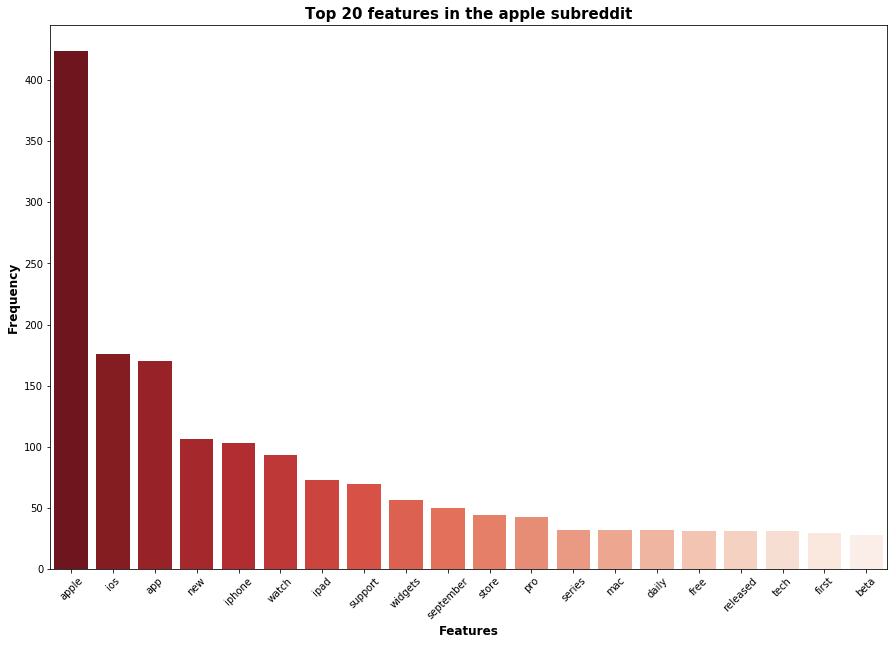

In [31]:
plt.figure(figsize=(15,10))
sns.barplot(x=apple_topfeat['word'],y=apple_topfeat['frequency'].sort_values(ascending=False),
            palette="Reds_r")
plt.title('Top 20 features in the apple subreddit', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Features', fontsize=12, fontweight='semibold')
plt.ylabel('Frequency', fontsize=12, fontweight='semibold');

In [32]:
#top 20 features in the android subreddit
android_topfeat = get_feat(df['title'][df['subreddit']==0], df_name='android_topfeat')

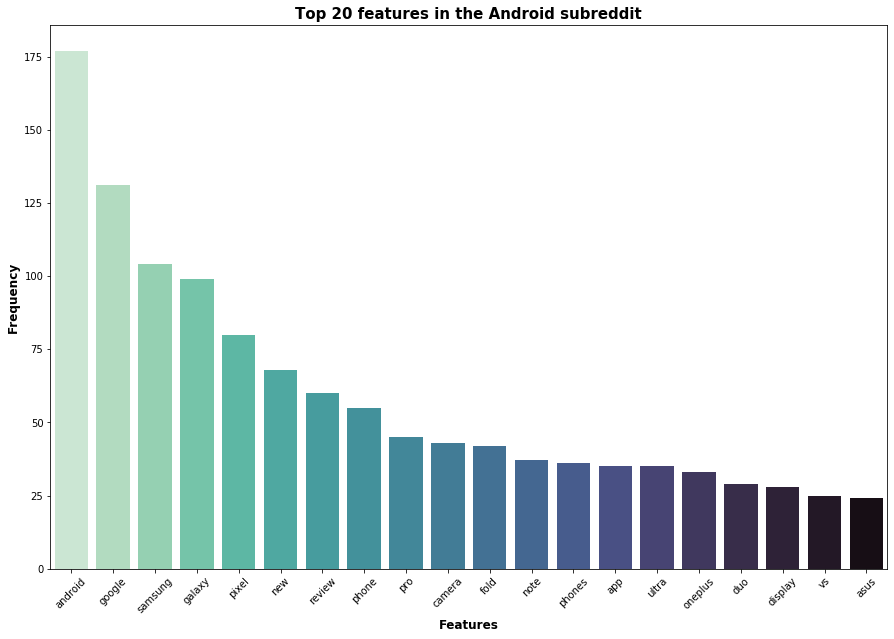

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(x=android_topfeat['word'],y=android_topfeat['frequency'].sort_values(ascending=False),
            palette="mako_r")
plt.title('Top 20 features in the Android subreddit', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Features', fontsize=12, fontweight='semibold')
plt.ylabel('Frequency', fontsize=12, fontweight='semibold');

Venn Diagram below shows the top 20 features for both subreddits.
There are 3 common words 'pro', 'app', and 'new' .


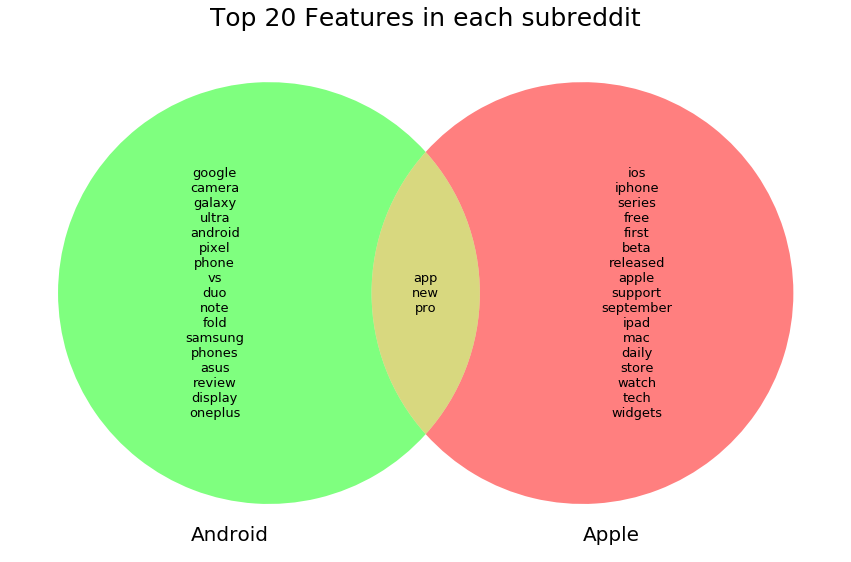

In [34]:
#plot the venn diagram
plt.figure(figsize=(15,15))
plt.title('Top 20 Features in each subreddit',fontsize=25)

set_a = set(android_topfeat['word'])
set_b = set(apple_topfeat['word'])

venn = venn2([set_a,set_b],set_labels=['Android','Apple'], 
             set_colors=('lime', 'red'), alpha = 0.5)


venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

print('Venn Diagram below shows the top 20 features for both subreddits.')
print('There are 3 common words \'pro\', \'app\', and \'new\' ''.')

### Export cleaned dataframe

In [35]:
#Export to csv.
df.to_csv('../datasets/cleaned_df.csv', index=False)

<div style="text-align: right">
    <div class="right"> >>> <b>Next: </b>
        <a href="./03_preprocessing_and_modeling.ipynb">Preprocessing and Modeling</a>
    </div>
    </div>

[Go to top](#top)

---